# KAJMANOSYS
This would be NBA analysis based on kaggle database 2012-2018 box scores.



In [289]:
import numpy as np
import pandas as pd
import seaborn as sns

#import plotly.express as px

bs = pd.read_csv('C:\\Users\\Karol\\Desktop\\datareminder\\nba\\kaggle_stats\\2012-18_officialBoxScore.csv')
pbs = pd.read_csv('.\\kaggle_stats\\2012-18_playerBoxScore.csv')
tbs = pd.read_csv('C:\\Users\\Karol\\Desktop\\datareminder\\nba\\kaggle_stats\\tbs_kajmanosys_fixabb2.csv')
additional_tbs = pd.read_csv('C:\\Users\\Karol\\Desktop\\datareminder\\nba\\kaggle_stats\\2012-18_teamBoxScore.csv')
tbsall = pd.read_csv('C:\\Users\\Karol\\Desktop\\datareminder\\nba\\kaggle_stats\\tbsall_1.csv')




In [276]:
additional_tbs = additional_tbs[['gmDate', 'teamAbbr', 'teamLoc', 'teamRslt', 'teamDayOff',  'opptAbbr',  'opptDayOff','teamPTS',  'opptPTS']]

additional_tbs['gameID'] =''
additional_tbs.loc[additional_tbs['teamAbbr'] == 'SA', 'teamAbbr'] = 'SAS'
additional_tbs.loc[additional_tbs['teamAbbr'] == 'NO', 'teamAbbr'] = 'NOP'
additional_tbs.loc[additional_tbs['teamAbbr'] == 'GS', 'teamAbbr'] = 'GSW'
additional_tbs.loc[additional_tbs['teamAbbr'] == 'NY', 'teamAbbr'] = 'NYK'

additional_tbs.loc[additional_tbs['opptAbbr'] == 'SA', 'opptAbbr'] = 'SAS'
additional_tbs.loc[additional_tbs['opptAbbr'] == 'NO', 'opptAbbr'] = 'NOP'
additional_tbs.loc[additional_tbs['opptAbbr'] == 'GS', 'opptAbbr'] = 'GSW'
additional_tbs.loc[additional_tbs['opptAbbr'] == 'NY', 'opptAbbr'] = 'NYK'
additional_tbs.loc[additional_tbs['teamLoc'] == 'Away', ['gameID']] = additional_tbs['gmDate'] + additional_tbs['teamAbbr'] + additional_tbs['opptAbbr'] 
additional_tbs.loc[additional_tbs['teamLoc'] == 'Home', ['gameID']] = additional_tbs['gmDate'] + additional_tbs['opptAbbr'] + additional_tbs['teamAbbr'] 

additional_tbs['gameID'] = additional_tbs['gameID'].str.replace('-','')
additional_tbs = additional_tbs[additional_tbs['teamLoc'] == 'Home']

tbsall = tbsall.merge(additional_tbs, on='gameID') 

additional_tbs

,gmDate,teamAbbr,teamLoc,teamRslt,teamDayOff,opptAbbr,opptDayOff,teamPTS,opptPTS,gameID
1,2012-10-30,CLE,Home,Win,0,WAS,0,94,84,20121030WASCLE
3,2012-10-30,MIA,Home,Win,0,BOS,0,120,107,20121030BOSMIA
5,2012-10-30,LAL,Home,Loss,0,DAL,0,91,99,20121030DALLAL
7,2012-10-31,PHI,Home,Win,0,DEN,0,84,75,20121031DENPHI
9,2012-10-31,TOR,Home,Loss,0,IND,0,88,90,20121031INDTOR
...,...,...,...,...,...,...,...,...,...,...
14749,2018-04-11,ORL,Home,Win,2,WAS,1,101,92,20180411WASORL
14751,2018-04-11,PHI,Home,Win,1,MIL,2,130,95,20180411MILPHI
14753,2018-04-11,LAC,Home,Loss,2,LAL,1,100,115,20180411LALLAC
14755,2018-04-11,POR,Home,Win,2,UTA,1,102,93,20180411UTAPOR


In [277]:
'''Usunięcie pierwszych meczów sezonu - nie ma sensu analiza tutaj'''
tbsall = tbsall[tbsall['avgPTS']!= 0.0]

In [278]:
tbsall[tbsall['season']==2018]

,Unnamed: 0,gameID,season,teamAbbr_x,avgPTS,avgAST,avgTO,avgSTL,avgBLK,avgPF,...,awayAbbr,gmDate,teamAbbr_y,teamLoc,teamRslt,teamDayOff,opptAbbr,opptDayOff,teamPTS,opptPTS
6155,6155,20171018MILBOS,2018,BOS,99.000000,24.000000,10.000000,11.000000,4.000000,24.000000,...,MIL,2017-10-18,BOS,Home,Loss,0,MIL,0,100,108
6161,6161,20171018HOUSAC,2018,SAC,-122.000000,-28.000000,-12.000000,-9.000000,-5.000000,-16.000000,...,HOU,2017-10-18,SAC,Home,Loss,0,HOU,0,100,105
6165,6165,20171020ATLCHA,2018,CHA,-27.000000,-4.000000,4.000000,-7.000000,-3.000000,-3.000000,...,ATL,2017-10-20,CHA,Home,Win,2,ATL,1,109,91
6166,6166,20171020PORIND,2018,IND,16.000000,7.000000,-2.000000,4.000000,2.000000,5.000000,...,POR,2017-10-20,IND,Home,Loss,2,POR,1,96,114
6167,6167,20171020CLEMIL,2018,MIL,6.000000,0.000000,-2.000000,3.000000,0.000000,-3.000000,...,CLE,2017-10-20,MIL,Home,Loss,1,CLE,2,97,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7374,7374,20180411WASORL,2018,ORL,-3.358025,-1.814815,-0.185185,-0.370370,0.580247,-2.086420,...,WAS,2018-04-11,ORL,Home,Win,2,WAS,1,101,92
7375,7375,20180411MILPHI,2018,PHI,2.938272,3.740741,2.876543,-0.555556,-0.308642,0.728395,...,MIL,2018-04-11,PHI,Home,Win,1,MIL,2,130,95
7376,7376,20180411LALLAC,2018,LAC,1.111111,-1.481481,-1.209877,-0.037037,-0.111111,-1.135802,...,LAL,2018-04-11,LAC,Home,Loss,2,LAL,1,100,115
7377,7377,20180411UTAPOR,2018,POR,1.382716,-2.975309,-1.061728,-1.716049,-0.012346,-0.148148,...,UTA,2018-04-11,POR,Home,Win,2,UTA,1,102,93


In [317]:
tbs['teamGameNumber'] = list(map(lambda x : len(tbs[(tbs['teamAbbr'] == tbs.iloc[x]['teamAbbr']) & 
                                                   (tbs['gameID'] < tbs.iloc[x]['gameID']) &
                                                   (tbs['season'] == tbs.iloc[x]['season'])])+1, tbs.index.values))

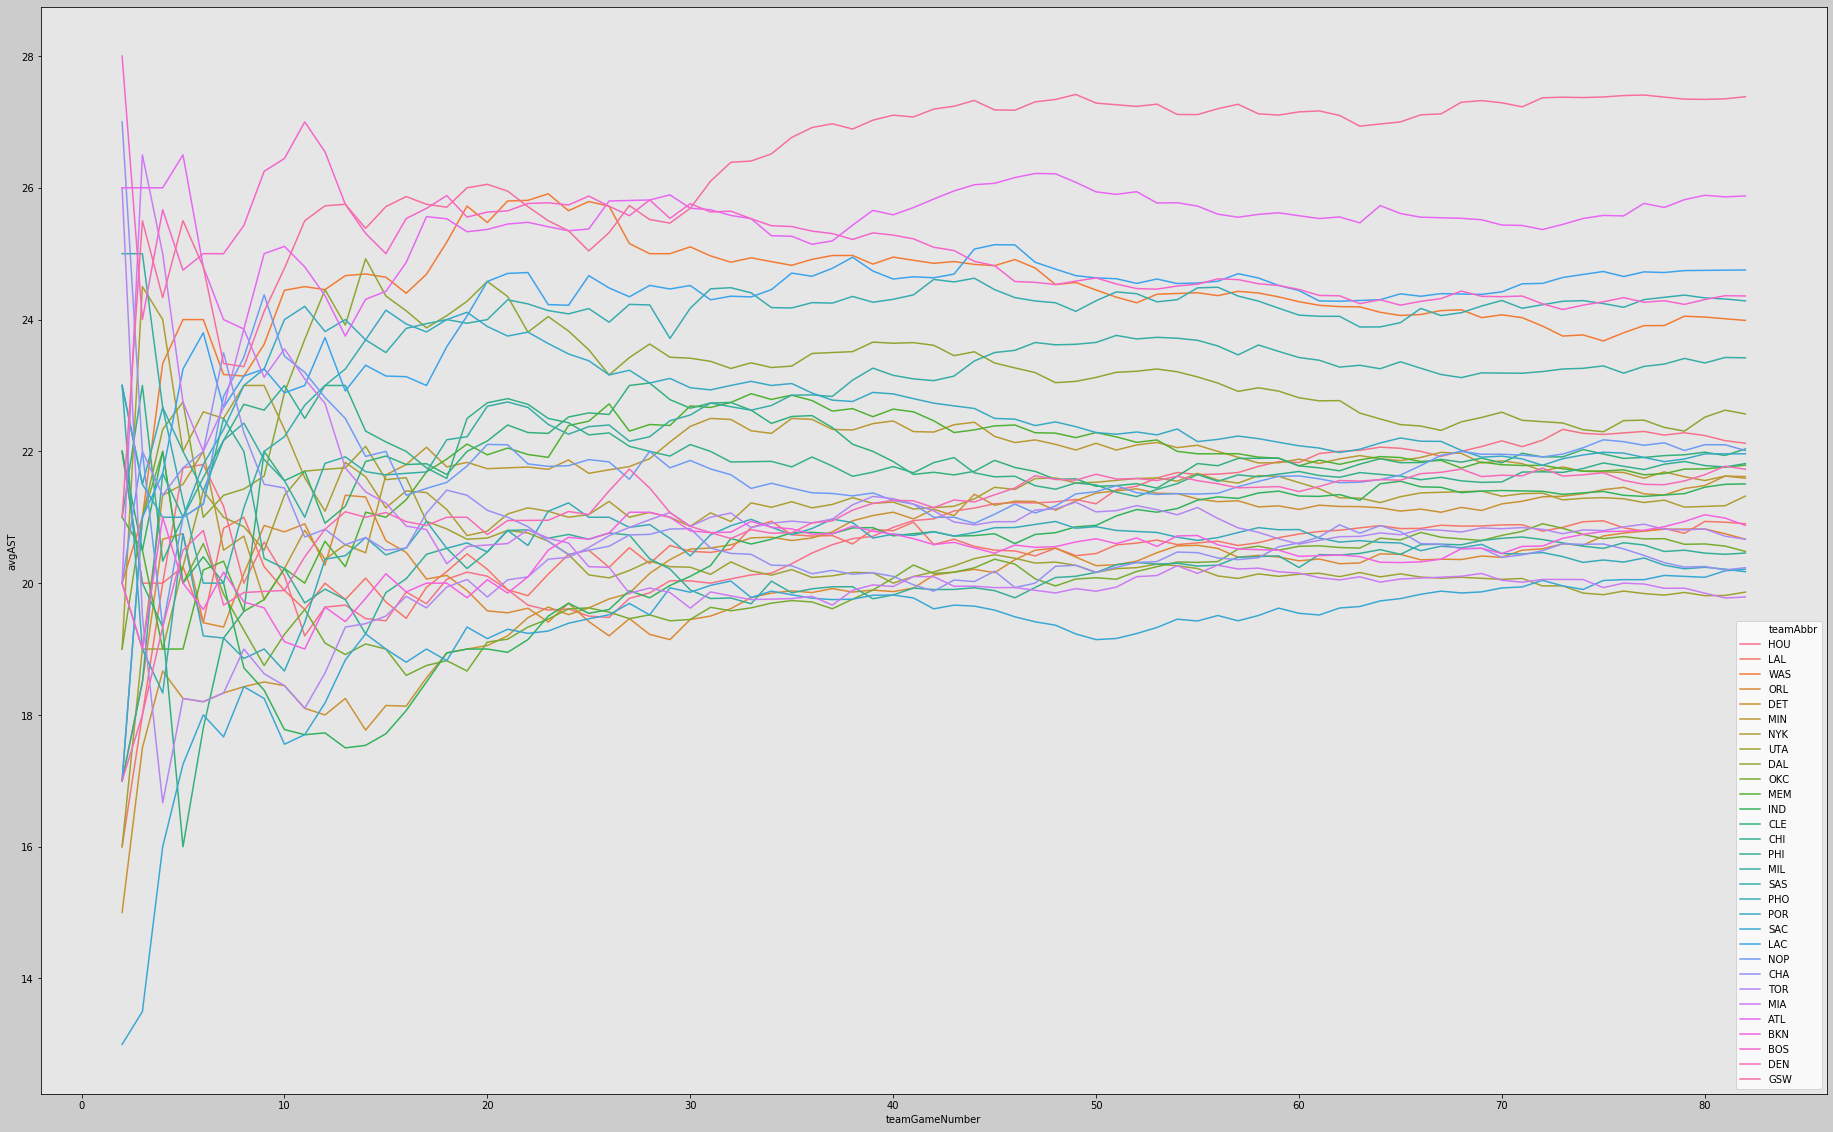

In [342]:
#fig = px.line(tbs[tbs['season']==2015], y='avgAST', color='teamAbbr')
tbs[tbs['teamAbbr']=='BOS']

plt.figure(figsize=(32,20),
            facecolor='#cccccc')
ax = sns.lineplot(x='teamGameNumber' ,y='avgAST',
                 hue='teamAbbr', data=tbs[np.logical_and(tbs['season']==2015, tbs['teamGameNumber']!=1)])
ax.set_facecolor('#e6e6e6')

#fig

# Let's start some AI cause I'm bored.

In [279]:
from sklearn.model_selection import train_test_split
data_columns = ['avgPTS','avgAST','avgTO','avgSTL','avgBLK','avgPF','avgFGA','avgFGM','avg2PA','avg2PM','avg3PA','avg3PM','avgFTA','avgFTM','avgORB','avgDRB',  'varPTS','varAST','varTO','varSTL','varBLK','varPF','varFGA','varFGM','var2PA','var2PM','var3PA','var3PM','varFTA','varFTM','varORB','varDRB','teamDayOff', 'opptDayOff']
target  = ['teamRslt']

tbsall = tbsall.reset_index(drop=True)
#tbsall = tbsall.drop(columns=['Unnamed: 0'])

X, y = tbsall[data_columns].values, tbsall[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05 )

#shuffle_index = np.random.permutation(6079)
#x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]


In [280]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.6493150684931507

In [281]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.6027397260273972